In [2]:
import pandas as pd
import geopandas as gpd
from h3_utils import *
import h3
import h3pandas

import ee
ee.Initialize()

import geemap

In [3]:
nga = gpd.read_file(r'..\data\Nigeria_-_State_Boundaries.zip')

In [4]:
ss = ['Abia', 'Anambra', 'Ebonyi', 'Enugu', 'Imo']

In [5]:
south_states = nga[nga['statename'].isin(ss)]

In [6]:
africapolis = gpd.read_file(r'../data/AFRICAPOLIS2020.zip')

In [7]:
south_states_africapolis = gpd.sjoin(africapolis, south_states)

<Axes: >

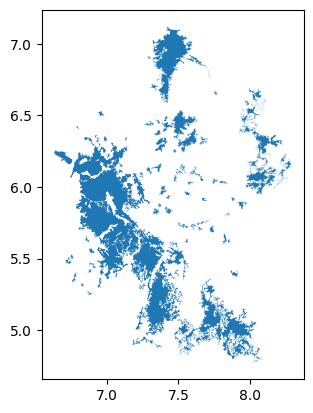

In [8]:
south_states_africapolis.plot()

In [9]:
south_states_africapolis.shape

(105, 30)

In [10]:
south_states_africapolis.head()

,agglosID,agglosName,ISO3,Longitude,Latitude,Pop2015,builtUp,Voronoi,Pop1950,Pop1960,...,uniq_id,timestamp,editor,statename,statecode,capcity,source,geozone,SHAPE_Leng,SHAPE_Area
10,6843,No name,NGA,6.747,5.513,13000,3.920084,222,0,0,...,1169,2018-12-13,abraham.oluseye,Imo,IM,Owerri,WHO,SEZ,2.794305,0.416382
111,6954,Obudi,NGA,6.888,5.556,33010,8.286370,209,0,0,...,1169,2018-12-13,abraham.oluseye,Imo,IM,Owerri,WHO,SEZ,2.794305,0.416382
137,6943,Obigwo,NGA,6.906,5.451,21000,5.839721,91,0,0,...,1169,2018-12-13,abraham.oluseye,Imo,IM,Owerri,WHO,SEZ,2.794305,0.416382
138,6944,Obilokwu Mbieri,NGA,7.126,5.530,10545,5.528838,630,0,0,...,1169,2018-12-13,abraham.oluseye,Imo,IM,Owerri,WHO,SEZ,2.794305,0.416382
139,6945,Obinze,NGA,6.962,5.407,11805,7.838418,181,0,0,...,1169,2018-12-13,abraham.oluseye,Imo,IM,Owerri,WHO,SEZ,2.794305,0.416382


In [11]:
hex8 = hex_generator(south_states,8)

Starting...
Done
Generating hex at level 8
Done


In [12]:
hex8.head()

,hex8,geometry
0,88588938a7fffff,"POLYGON ((7.37666 6.83146, 7.37557 6.82731, 7...."
1,8882da35ebfffff,"POLYGON ((6.82990 5.35398, 6.82885 5.34994, 6...."
2,88588b355bfffff,"POLYGON ((7.08371 6.13347, 7.08263 6.12937, 7...."
3,8858894f59fffff,"POLYGON ((6.86361 6.67349, 6.86254 6.66936, 6...."
4,8882da12d3fffff,"POLYGON ((7.29641 5.13563, 7.29534 5.13159, 7...."


Earth engine workflow

In [13]:
hexagons_gee_list = []
if hex8.shape[0]>1000:
    chunks = int(np.ceil(hex8.shape[0]/1000))

    for i in range(1,chunks+1):
        if i!=chunks:
            temp = hex8.iloc[(i-1)*1000:i*1000]
            hexagons_gee_list.append(geemap.gdf_to_ee(temp))
        
        if i==chunks:
            temp = hex8.iloc[(i-1)*1000:]
            hexagons_gee_list.append(geemap.gdf_to_ee(temp))

else:
    hexagons_gee_list.append(geemap.gdf_to_ee(hex8))



In [14]:
south_states_gee = geemap.gdf_to_ee(south_states)

In [34]:
water=ee.Image('JRC/GSW1_0/GlobalSurfaceWater').select('occurrence')
notWater= water.mask().Not()
# create a summer filter
sumFilter = ee.Filter.dayOfYear(31,121)

def cloudMask(cloudyScene):
    scored=ee.Algorithms.Landsat.simpleCloudScore(cloudyScene)
    mask=scored.select(['cloud']).lte(10)
    return cloudyScene.updateMask(mask)


col = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA') \
   .filterDate('2018-01-01', '2023-01-01') \
   .filter(sumFilter) \
   .filterBounds(south_states_gee) \
   .map(cloudMask)

image=col.median()

thermal=image.select('B10') \
   .updateMask(notWater)

ndvi=ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
   .filterDate('2018-01-01', '2023-01-01') \
   .filter(sumFilter) \
   .filterBounds(south_states_gee) \
   .median() \
   .normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI') \
   .updateMask(notWater)


# minMax= ndvi.reduceRegion({ \
#    'reducer': ee.Reducer.min().combine({ \
#        'reducer': ee.Reducer.max(), \
#        'sharedInputs': True \
#    }), \
#     'geometry': south_states_gee,
#    'scale': 30, \
#    'maxPixels': 1e9 \
# })

minMax= ndvi.reduceRegion(
   reducer=ee.Reducer.min().combine(
       reducer2=ee.Reducer.max(), 
       sharedInputs=True 
   ), 
    geometry=south_states_gee,
   scale=30, 
   maxPixels=1e9 
)

min_ndvi=ee.Number(minMax.get('NDVI_min'))
max_ndvi=ee.Number(minMax.get('NDVI_max'))

# fractional vegetation
fv=ndvi.subtract(min_ndvi).divide(max_ndvi.subtract(min_ndvi)).rename('FV')

# Now we use an empirical model of emissivity based on this fractional vegetation cover (Sekertekin and Bonafoni 2020).
a=ee.Number(0.004)
b=ee.Number(0.986)
em=fv.multiply(a).add(b).rename('EMM').updateMask(notWater)

lstLandsat=thermal.expression(
   '(Tb/(1 + (0.001145* (Tb / 1.438))*log(Ep)))-273.15',{
       'Tb': thermal.select('B10'),
       'Ep': em.select('EMM')
   }).updateMask(notWater)



In [48]:
south_states

,FID,globalid,uniq_id,timestamp,editor,statename,statecode,capcity,source,geozone,SHAPE_Leng,SHAPE_Area,geometry
20,21,80db4727-d196-4bd9-9b36-51f728d80de2,1165,2018-12-13,abraham.oluseye,Anambra,AN,Awka,eHA_Polio,SEZ,3.624593,0.393537,"POLYGON ((6.86365 5.74933, 6.86324 5.74965, 6...."
24,25,d4bea7a2-3d76-4985-938c-61dd493be2cb,1169,2018-12-13,abraham.oluseye,Imo,IM,Owerri,WHO,SEZ,2.794305,0.416382,"POLYGON ((7.38548 5.50336, 7.38477 5.50151, 7...."
28,29,5a651043-340f-4235-9270-bdff3be5ecc3,1174,2018-12-13,abraham.oluseye,Abia,AB,Umuahia,WHO,SEZ,4.566081,0.391390,"POLYGON ((7.47943 4.92413, 7.47872 4.91954, 7...."
34,35,7d0f6cce-4fc4-4562-aed6-c1e297dcff20,1170,2018-12-13,abraham.oluseye,Enugu,EN,Enugu,WHO,SEZ,4.380752,0.623461,"POLYGON ((7.53338 6.01098, 7.52006 6.02002, 7...."
36,37,7f949ae4-887f-4fe0-99a4-3d09aaa27d0e,1173,2018-12-13,abraham.oluseye,Ebonyi,EB,Abakaliki,eHA_Polio,SEZ,4.424806,0.530099,"POLYGON ((7.59936 5.95737, 7.61311 5.95198, 7...."


In [56]:
for statename in south_states['statename'].to_list():
    temp = geemap.gdf_to_ee(south_states[south_states['statename']==statename])
    geemap.ee_export_image_to_drive(lstLandsat, f"{statename}_UHI.tif", scale=30, crs="epsg:4326", region=temp.geometry(), folder='earthengine')

In [63]:
south_states['statename'].to_list()

['Anambra', 'Imo', 'Abia', 'Enugu', 'Ebonyi']

In [65]:
geemap.ee_export_image_to_asset(lstLandsat, "UHI.tif", scale=30, assetId='uhi', crs="epsg:4326", region=south_states_gee.geometry())

In [17]:
from geemap import Map

In [38]:
Map = geemap.Map(center=[5.6, 6.36], zoom=12)
# Map.addLayer(em, {'palette': ['blue', 'white', 'green'], 'min': 0.98, 'max': 0.99})
Map.addLayer(lstLandsat,
             {'palette': ['blue', 'white', 'red'], 'min': 25, 'max': 35})
Map

Map(center=[5.6, 6.36], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(c…

In [37]:
print('Start GEE')

for idx, hex_gee in enumerate(hexagons_gee_list):
    out_path = '../data/uhi/hex8'
    out_dir = os.path.join(out_path)
    out_file_path = os.path.join(out_dir, f'hex8_uhi_{idx}.csv')

    if not os.path.exists(out_dir):
        os.makedirs(out_dir)



    geemap.zonal_statistics(lstLandsat, hex_gee, out_file_path, statistics_type='MEAN', scale=30)

Start GEE
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to d:\GitHub\BluePaleDot\data\uhi\hex8\hex8_uhi_0.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to d:\GitHub\BluePaleDot\data\uhi\hex8\hex8_uhi_1.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to d:\GitHub\BluePaleDot\data\uhi\hex8\hex8_uhi_2.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to d:\GitHub\BluePaleDot\data\uhi\hex8\hex8_uhi_3.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to d:\GitHub\BluePaleDot\data\uhi\hex8\hex8_uhi_4.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to d:\GitHub\BluePaleDot\data\uhi\hex8\hex8_uhi_5.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to d:\GitHub\BluePaleDot\data\uhi\hex8\hex8_uhi_6.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to d